### Content below code

In [1]:
import itertools as it
import functools as ft
import operator as op

import math
import numpy as np
import scipy as sp
import random
import numba
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import Normalize as norma

In [2]:
with open('Sr_reg_test_2.npy', 'rb') as f:
    results = np.load(f)
names = ['Trading Grid', 'Cubic Spline', 'Quadratic Interpolation', 'Regression Kriging']
names.reverse()
comps = [100*2**j for j in range(11)]

# model, comp, iters, del/rho, S, r
# (4, 11, 20, 2, 21, 21)
mean_results = np.zeros((4,11,2,21,21))
for j, k, l, m, n in it.product(range(4), range(11), range(2), range(21), range(21)):
    mean_results[j,k,l,m,n] = np.mean(results[j,k,:,l,m,n])

In [3]:
def show_err_v_comp():
    # rel MAE vs comp time
    fig, ax = plt.subplots(1,2)
    for j in range(3,-1,-1):
        ax[0].plot([np.mean(results[j,k]) for k in range(11)])
    ax[0].legend(names)
    for j in range(3,0,-1):
        ax[1].plot([np.mean(results[j,k]) for k in range(11)])
    ax[1].legend(names[:-1])

    plt.suptitle('Mean Absolute Error by Computation Time')
    plt.xlabel('MC simulations')

    xslice = slice(0,11,3)
    ax[0].set_xticks(list(range(11))[xslice])
    ax[0].set_xticklabels(comps[xslice])
    ax[1].set_xticks(list(range(11))[xslice])
    ax[1].set_xticklabels(comps[xslice])
    ax[0].set_ylabel('Mean absolute error (percent true value)')
    plt.show()

In [4]:
def show_heatmaps(algo):
    MC_ind = [1,4,7]
    cmap = 'viridis'
    
    fig, ax = plt.subplots(2,3,figsize=(13,6),sharex=True,sharey=True)
    fig.suptitle('Greek Estimation Error Distribution')
    ax[1,0].set_xlabel('200 MC runs')
    ax[1,1].set_xlabel('1.6k MC runs')
    ax[1,2].set_xlabel('13k MC runs')
    ax[0,0].set_ylabel('Delta')
    ax[1,0].set_ylabel('Rho')

    ax[0,0].set_xticks([0,10,20])
    ax[0,0].set_xticklabels(['-20 bp','r_0','+20 bp'])
    ax[0,0].set_yticks([0,10,20])
    ax[0,0].set_yticklabels(['-10% S','S_0','+10% S'])
    
    for j in range(2):
        for k in range(3):
            ax[j,k].imshow(mean_results[algo,MC_ind[k],j], cmap=cmap)
            fig.colorbar(cm.ScalarMappable(norm=norma(0,np.max(mean_results[algo,MC_ind[k],j])), cmap=cmap), ax=ax[j,k])
    
    plt.show()

# Regression in (S,r)-space

This section reports the results of our experiments with extending the results of limited numbers of MC runs in $(S,r)$ space to estimates of $\tilde\Delta$ and $\rho$ over deviations of up to 10% in $S$ and up to 20 bp in $r$.

The key take-aways are as follows:
- Our preferred technique is quadratic interpolation, largely for its simplicity.
- Regression kriging might have a small advantage over the others for low computation time.
- It might be possible to implement the cubic spline approach described below with minimal change to current procedure at Securian.

There are a few things that we've noticed about this regression problem, in general:
- It's better to estimate $\tilde\Delta$ and $\rho$ directly than to estimate $V$ or its higher-order derivatives and then use calculus.
- It's better to obtain precise estimates of the Greeks at few (4-5) points than to get imprecise estimates at many points.
- Any sane technique that follows the above two guidelines and isn't too sensitive to noise will produce roughly equivalent results.

Here is a picture of mean absolute error (normalized to the true magnitude of $\tilde\Delta$/$\rho$) and computation time (in number of base MC runs). I should note at the outset that these are different from the ones reported during the presentation; this improvement was achieved by switching to smoothing splines.

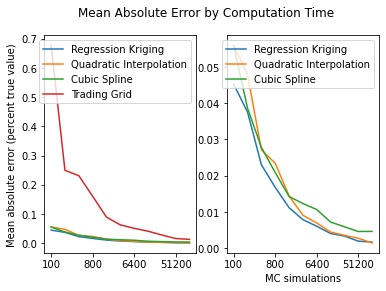

In [5]:
show_err_v_comp()

Mean absolute error is computed over deviations of up to 10% in $S$ and 20 bp in $r$; no claims are made about relative model performance beyond that range. Note that computation time here is benchmarked to theoretically optimal cluster sampling rather than the way these quantities are actually computed in gmab_model; also elided are differences between the time required to compute $\tilde\Delta$ and $\rho$.

The data used to produce this and other figures is stored in the file Sr_reg_test_2.npy, which was produced with the script results_workbook.py

Each method in the graph is discussed in turn in the following subsections.

### Trading Grid

There is a certain irony in this method being named 'the trading grid', as it is the least grid-like of all methods we tried.

This method is based on some notes we were given (GMxB Trading Grid, Gary Hatfield) that described an interpolation technique modeled after what is used in practice. Around some point $(S_0,r_0)$, sample as follows:
$$V, \rho, \rho_r \text{ at }(S_0,r_0)$$
$$V\text{ at }(S_0\pm 1\%,r_0),(S_0\pm 2\%,r_0),(S_0\pm 3\%,r_0),(S_0\pm 5\%,r_0),(S_0\pm 10\,r_0)$$

Connect the estimates for $V$ by a spline $P(S,r_0)$. Extend $P$ to all of $(S,r)$ by:
$$P(S,r) = P(S,r_0) + (r-r_0)\rho(S_0,r_0) + (r-r_0)^2\rho_r(S_0,r_0)/2$$
and then differentiate to get:
$$\tilde\Delta(S,r) = \frac{\partial}{\partial S}P(S,r)$$
$$\rho(S,r) = \frac{\partial}{\partial r}P(S,r)$$

Here are heatmaps showing how this model performs:

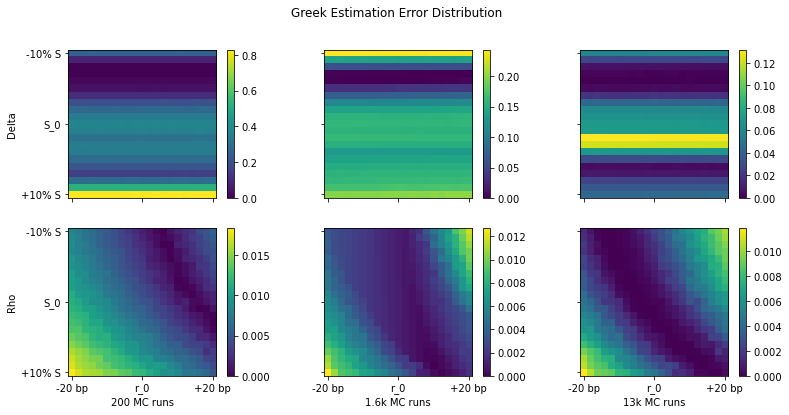

In [6]:
show_heatmaps(0)

This figure shows the normalized mean absolute error over 20 simulations for each of 400 points around $(S_0,r_0)$. Brighter points have worse error, with the associated mean absolute error reported _as a multiple_ of the true value.

By any measure, the performance of this interpolation technique is very bad. It's plausible that some of that has to do with our implementation of the technique, but it seems to be true in general that estimating Greeks indirectly via differentiation of an estimate of $V$ produces worse estimates for $\tilde\Delta$ and $\rho$.

### Cubic Spline

This is also a bad name for a method, for two reasons: first, both this and the trading grid are formed on splines on the line $(S,r_0)$ and, second, the splining method is now a smoothing spline as opposed to a strictly interpolated cubic spline.

The cubic spline method discussed here is designed to be similar to the trading grid, while leveraging the insights obtained from investigating other methods. Like the trading grid, we construct a spline through the point $(S_0,r_0)$ by performing MC estimation at points on the line $(S,r_0)$. Unlike the trading grid, we perform cluster-estimates of $\tilde\Delta$ and $\rho$ at each point.

- Estimate $\tilde\Delta$, $\rho$, $\tilde\Delta_r=\frac{\partial^2V}{\partial S\partial r}$ and $\rho_r=\frac{\partial^2V}{\partial r^2}$ at  points $(S,r)\in\{(S_j,r_0)\}$.
- Connect those estimates with smoothing splines $$P(S,r_0)\approx \tilde\Delta(S,r_0)$$ $$Q(S,r_0)\approx \tilde\Delta_r(S,r_0)$$ $$R(S,r_0)\approx \rho(S,r_0)$$ $$T(S,r_0)\approx \rho_r(S,r_0)$$
- Extend $P$ and $R$ to all of $(S,r)$-space as $$P(S,r) = P(S,r_0) + (r-r_0)Q(S,r_0)$$ $$R(S,r) = R(S,r_0) + (r-r_0)T(S,r_0)$$

Here are the heatmap of results:

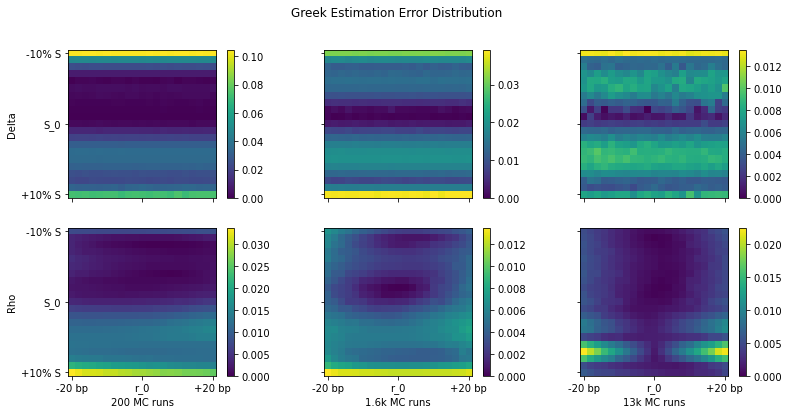

In [7]:
show_heatmaps(1)

Performance is much better better than that acheived by the trading grid approach for $\tilde\Delta$ and comparable for $\rho$ except for a few hot-spots. Because $\tilde\Delta$ is the Greek that is harder to approximate over this domain, the overall error profile is much better.

Performance is comparable to that achieved by quadratic interpolation and regression kriging.

##### Sampling on $(S,r_0)$ and transition from trading grid

We tried several methods for choosing points on $(S,r_0)$ to compute derivatives; the ones reported here are the result of sampling at the Chebyshev nodes in the range of $\pm 10$% change in $S$. Modifying the cubic spline approach to sample at the sampe points as the trading grid decreases performance, but the cubic spline retains its advantage.

I mention this because, as a proof of concept, it might be possible to test this cubic spline approach without interrupting the daily estimation of Greeks: turn the estimates that are currently obtained away from $(S_0,r_0)$ into cluster samples to estimate the Greeks there, and run both interpolation methods on the same data.

### Quadratic Interpolation

This quadratic interpolation method for regression is straightforward. Choose 5 points in $(S,r)$-space, then fit a polynomial in $S$, $r$, $S^2$ and $Sr$ to those points. The points chosen were: $$(S,r)\in\{(-14\%,-9bp),(-16\%,+9bp),(+0,+0),(+12\%,-11bp),(+12\%,+5bp)\}$$

Here is a heatmap of results:

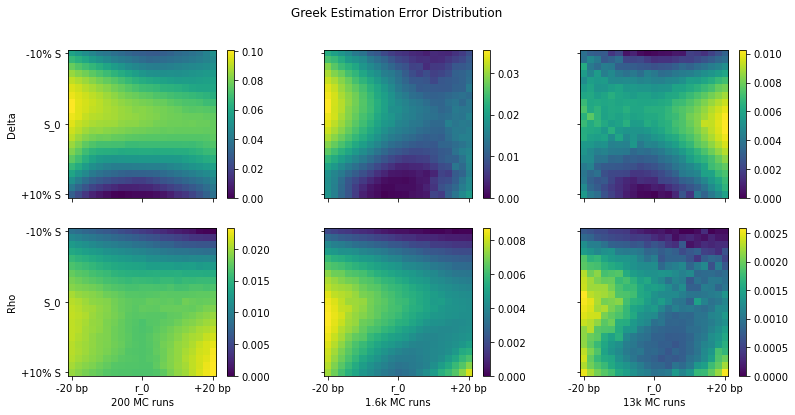

In [8]:
show_heatmaps(2)

The performance of this interpolation method is good, approximately at the same level as the cubic spline.

My suspicion is that a lot of the relative difference in performance between this quadratic interpolation method and the other two good methods is due to choices in point-sampling. This implementation fits a polynomial in $S$, $r$, $S^2$ and $Sr$ to five points, which leaves no degrees of freedom. In contrast, the kriging regression implementation performs kriging on the residuals of a polynomial in $S$ and $r$ regressed on four points. Intuitively, I feel that the greater rigidity of this quadratic interpolation implementation increases the responsiveness to noise, degrading its performance under conditions of low computation time.

Another difference between the sampling methodologies - less philosophical, and perhaps more important - is that the fitting points for quadratic interpolation were chosen to be much further away from each other, and the origin, than those chosen for regression kriging. 

### Regression Kriging / Gaussian Process Regression

Regression kriging is a two-step interpolation method. First, a polynomial regression is performed, and then a mean-zero Gaussian process regression is performed on the residuals.

I performed some testing on sample 5, and the best results I found were acheived by concentrating all MC simulations on the assessment of delta and rho at four points and fitting a linear regression $y = \beta_0 + \beta_1 S + \beta_2 r + \epsilon$. Those four points were: $$(S,r)\in\{(+9\%, +0),(-9\%, +0),(+0, +18bp),(+0, -18bp)\}$$

I experimented with a few standard kernels for the Gaussian process regression on the residuals, and the radial basis function (a.k.a squared exponential, a.k.a Gaussian kernel) performed the best. Much of the success of this method relies on the ability to specify a noise level for each measurement, namely the standard error associated to each estimate of V(S,r). This may be the most important aspect of the Gaussian process regression.

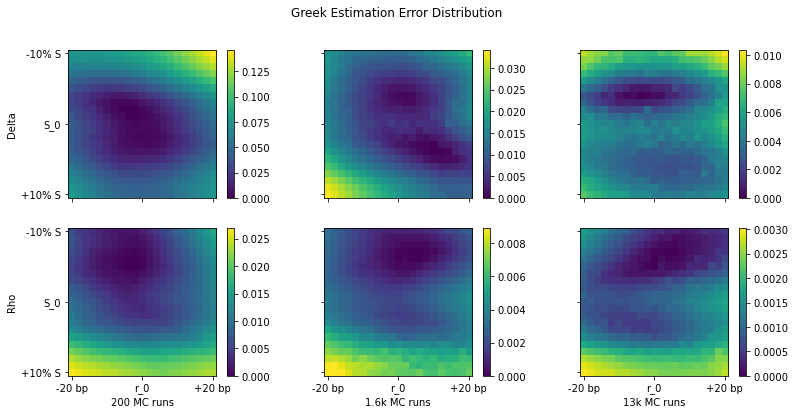

In [9]:
show_heatmaps(3)

This is, of course, one of the best techniques we have identified, and seems to perform better than quadratic interpolation with lower computational time. Whether because, as noted in the section of quadratic interpolation, this is due to sampling procedure or less rigidity in the model, this is particularly evident close to $(S_0,r_0)$, where already some of the surrounding region is computed to within a tolerance of 1% with only 200 MC runs.

It is possible that this difference is also due in part to the method used to generate noise between the models, this one using simulated noise rather than actual MC runs; we did not have the time to go back and determine whether that was the case.

##### Opportunities for future investigation

First, some low hanging fruit: our team has produced two interpolation schemes for generating proxy models with almost indistinguishable performance. To what extent is their performance independent? Is it possible to average their predictions and eke out an improvement over both?

Now, some technical considerations. Regression kriging seems to be conceptually very similar to but slightly less general than universal kriging, which we did not have the time to try. It is possible that switching to this more general model will improve results somewhat, perhaps in conjunction with a different sampling procedure.

The choice of kernel for Gaussian process regression entirely determines its suitability for different applications. The decision to use the radial basis function as the kernel for this situation was not made in a principled manner, and there is reason to believe that the kernel should exhibit different properties in the $S$ and $r$ directions. There is an opportity to investigate the true covariance function, knowledge of which will plausibly improve the performance of the model. In particular, it may have a strong bearing on the validity of the predictions made by this model outside of the range of shocks to $S$ and $r$ that we have considered.

Beyond being a regression technique, regression kriging is a statistical model that can produce estimates for standard error associatd to its predictions. Further, these estimates depend only on the locations and measurement errors of the observed points. It may be worth determining the degree to which these estimates correspond to observed deviations from model predictions, as they could be used to dynamically guide the placement of MC runs.